Demonstration of OBIA Classification

In [17]:
%matplotlib notebook

import numpy as np
import os
import scipy

from matplotlib import pyplot as plt
from matplotlib import colors
from osgeo import gdal
from skimage import exposure
from skimage.segmentation import quickshift, felzenszwalb
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

RASTER_DATA_FILE = "/Users/karla/Downloads/obia_data/image/2298119ene2016recorteTT.tif"
TRAIN_DATA_PATH = "/Users/karla/Downloads/obia_data/train/"
TEST_DATA_PATH = "/Users/karla/Downloads/obia_data/test/"

In [18]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize all the vectors in the given directory into a single image."""
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels

In [62]:
raster_dataset = gdal.Open(RASTER_DATA_FILE, gdal.GA_ReadOnly)

geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
n_bands = raster_dataset.RasterCount
bands_data = []
for b in range(1, n_bands+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

# print(bands_data)
bands_data = np.dstack(b for b in bands_data)
print("________")
rows, cols, bands = bands_data.shape
print(rows)
print(cols)
print(bands)

print(bands_data[2499,:,:])

________
2500
1000
7
[[ 61.4756012   51.94646072  42.27277756 ...,  93.85290527  13.12331867
    1.94712317]
 [ 61.73500061  51.89333344  42.07695389 ...,  93.4613266   13.11232376
    1.95029962]
 [ 61.30699158  51.81364059  41.90560532 ...,  94.9265976   13.04635429
    1.90000665]
 ..., 
 [ 63.14873123  53.50045776  44.15758133 ...,  67.64865112  11.67984486
    1.90371239]
 [ 63.13576126  53.68640518  44.83072662 ...,  68.31181335  11.95785904
    1.94659376]
 [ 62.65586853  53.1816864   43.44771957 ...,  66.60654449  11.3767004
    1.82853758]]


In [44]:
img = exposure.rescale_intensity(bands_data)
# create a stack of intensity values 
rgb_img = np.dstack([img[:, :, 4], img[:, :, 3], img[:, :, 2]])
print(img[:,:,1].shape)
print(img[:,:,4][0])

(2500, 1000)
[ 0.36003536  0.36239874  0.35808417  0.35256043  0.35247797  0.34662446
  0.31067887  0.32463938  0.30812308  0.30707881  0.32208362  0.34667942
  0.28899607  0.2639606   0.27313936  0.26885226  0.26214683  0.26981413
  0.27165538  0.26951182  0.35234058  0.335522    0.28022954  0.26313615
  0.27998221  0.33585176  0.30628186  0.28905106  0.30853534  0.30669406
  0.31023917  0.28847396  0.29550919  0.29495955  0.28888616  0.28627545
  0.2879518   0.28462654  0.28325248  0.29017779  0.29688323  0.2948496
  0.29424503  0.2885564   0.29094726  0.29262361  0.28987551  0.28874877
  0.28671515  0.2877869   0.2858907   0.28333494  0.28646782  0.28891364
  0.29135948  0.29570156  0.29677331  0.29792753  0.29921913  0.30273676
  0.3026818   0.30336884  0.30655664  0.30488029  0.3050727   0.30861777
  0.30798569  0.30828798  0.30237952  0.30081308  0.3026818   0.30584216
  0.30394593  0.30358869  0.30237952  0.30444062  0.30707881  0.30839792
  0.30913991  0.30718872  0.30477038  0

<IPython.core.display.Javascript object>


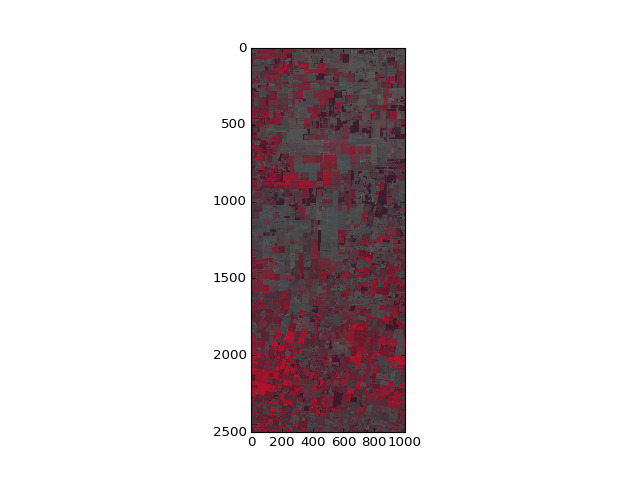

In [34]:
plt.figure()
plt.imshow(rgb_img)

In [64]:
segments_quick = quickshift(img, kernel_size=7, max_dist=3, ratio=0.35, convert2lab=False)
n_segments = len(np.unique(segments_quick))
print(n_segments)

26835


<IPython.core.display.Javascript object>


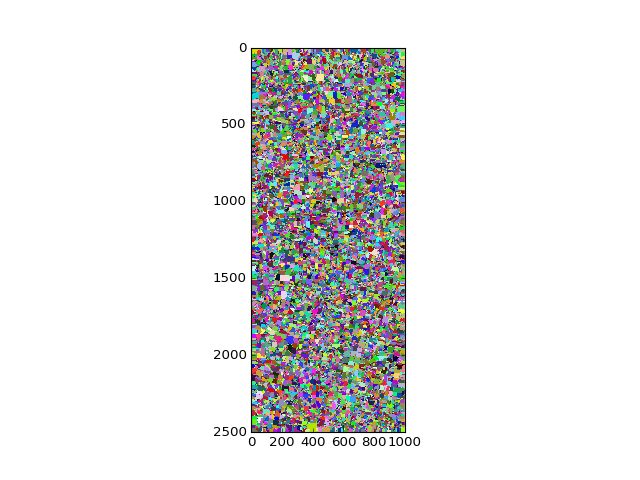

In [65]:
cmap = colors.ListedColormap(np.random.rand(n_segments, 3))
plt.figure()
plt.imshow(segments_quick, interpolation='none', cmap=cmap)

In [66]:
band_segmentation = []
for i in range(n_bands):
    band_segmentation.append(felzenszwalb(img[:, :, i], scale=85, sigma=0.25, min_size=9))

In [68]:
const = [b.max() + 1 for b in band_segmentation]
segmentation = band_segmentation[0]
for i, s in enumerate(band_segmentation[1:]):
    segmentation += s * np.prod(const[:i+1])

_, labels = np.unique(segmentation, return_inverse=True)
segments_felz = labels.reshape(img.shape[:2])

<IPython.core.display.Javascript object>


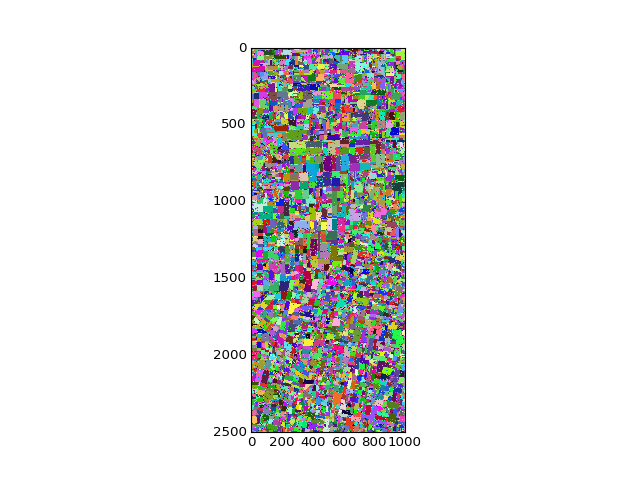

In [69]:
cmap = colors.ListedColormap(np.random.rand(len(np.unique(segments_felz)), 3))
plt.figure()
plt.imshow(segments_felz, interpolation='none', cmap=cmap)

<IPython.core.display.Javascript object>


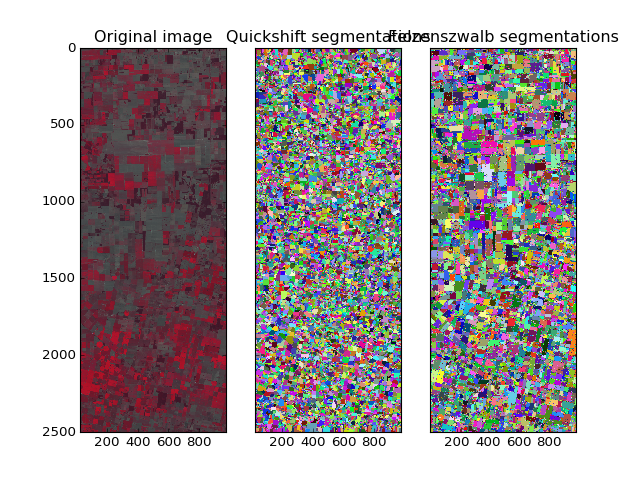

In [70]:
n_segments = max(len(np.unique(s)) for s in [segments_quick, segments_felz])
cmap = colors.ListedColormap(np.random.rand(n_segments, 3))
#SHOW_IMAGES:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.imshow(rgb_img, interpolation='none')
ax1.set_title('Original image')
ax2.imshow(segments_quick, interpolation='none', cmap=cmap)
ax2.set_title('Quickshift segmentations')
ax3.imshow(segments_felz, interpolation='none', cmap=cmap)
ax3.set_title('Felzenszwalb segmentations')
plt.show()

In [72]:
# We choose the quick segmentation
segments = segments_felz
segment_ids = np.unique(segments)
print("Felzenszwalb segmentation. %i segments." % len(segment_ids))

Felzenszwalb segmentation. 131168 segments.


In [73]:
rows, cols, n_bands = img.shape
files = [f for f in os.listdir(TRAIN_DATA_PATH) if f.endswith('.shp')]
classes_labels = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(TRAIN_DATA_PATH, f) for f in files if f.endswith('.shp')]
print(shapefiles)

['/Users/karla/Downloads/obia_data/train/C.shp', '/Users/karla/Downloads/obia_data/train/B.shp', '/Users/karla/Downloads/obia_data/train/A.shp', '/Users/karla/Downloads/obia_data/train/E.shp', '/Users/karla/Downloads/obia_data/train/D.shp']


In [74]:
ground_truth = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)

In [76]:
classes = np.unique(ground_truth)[1:]  # 0 doesn't count
len(classes)
print(classes)

[ 1.  2.  3.  4.  5.]


In [77]:
segments_per_klass = {}
for klass in classes:
    segments_of_klass = segments[ground_truth==klass]
    segments_per_klass[klass] = set(segments_of_klass)
    print("Training segments for class %i: %i" % (klass, len(segments_per_klass[klass])))

Training segments for class 1: 18
Training segments for class 2: 20
Training segments for class 3: 38
Training segments for class 4: 22
Training segments for class 5: 34


In [80]:
accum = set()
intersection = set()
for class_segments in segments_per_klass.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments
assert len(intersection) == 0

In [83]:
train_img = np.copy(segments)
threshold = train_img.max() + 1
for klass in classes:
    klass_label = threshold + klass
    for segment_id in segments_per_klass[klass]:
        train_img[train_img == segment_id] = klass_label
train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold

<IPython.core.display.Javascript object>


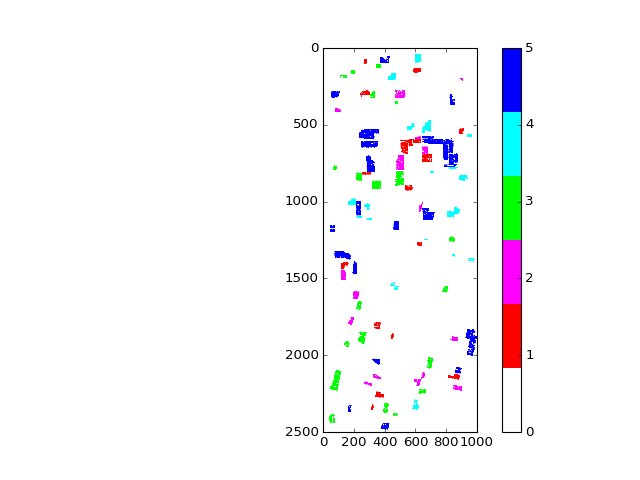

In [86]:
plt.figure()
cm = np.array([[ 1,  1,  1 ], [ 1,0,0], [ 1,0,1], [ 0,1,0], [ 0,1,1], [ 0,0,1]])
cmap = colors.ListedColormap(cm)
plt.imshow(train_img, cmap=cmap)
plt.colorbar(ticks=[0,1,2,3,4,5])

In [87]:
def segment_features(segment_pixels):
    """For each band, compute: min, max, mean, variance, skewness, kurtosis"""
    features = []
    n_pixels, n_bands = segment_pixels.shape
    for b in range(n_bands):
        stats = scipy.stats.describe(segment_pixels[:,b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if n_pixels == 1:
            # scipy.stats.describe raises a Warning and sets variance to nan
            band_stats[3] = 0.0  # Replace nan with something (zero)
        features += band_stats
    return features

In [ ]:
# This is the most heavy part of the process. It could take about half an hour to finish in a not-so-fast CPU
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    objects = []
    objects_ids = []
    for segment_label in segment_ids:
        segment_pixels = img[segments==segment_label]
        segment_model = segment_features(segment_pixels)
        objects.append(segment_model)
        # Keep a reference to the segment label
        objects_ids.append(segment_label)  

    print("Created %i objects" % len(objects))